In [1]:
# Import required packages

%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM, GRU, Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics

C:\Users\AURIMASSilva\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# read data and add aditional column (price movement)
df = pd.read_csv('fourGreta.csv')
df['UpOrDown'] = df['returns'].apply(lambda x : 1 if x > 0 else 0)

In [3]:
# get the values in form of numpy matrix
sentiment = df['sentiment'].values
returns = df['price'].values
upordown = df['UpOrDown'].values
assert len(sentiment) == len(returns) == len(upordown)

In [4]:
# scale returns to -1, 1
sc = MinMaxScaler(feature_range = (0,1))
sc.fit(returns.reshape(-1,1))
returns = sc.transform(returns.reshape(-1,1))
returns = returns.reshape(1,-1)[0]

In [5]:
# Generate time series 
data_gen = TimeseriesGenerator(np.append(sentiment,0.00), np.append(sentiment,0.00),
                                       length = 12, sampling_rate=1,
                                       batch_size=1)

# get features and targets from generated batches
features_sentiment = []
targets_sentiment = []
i = 0
while True:
    try:
        features_sentiment.append(list(data_gen[i][0][0]))
        targets_sentiment.append(data_gen[i][1][0])
        i += 1
    except:
        break
data_gen = TimeseriesGenerator(np.append(returns,0.00), np.append(upordown,0.00),
                                       length= 12, sampling_rate=1,
                                       batch_size=1)

# get features and targets from generated batches
features_returns = []
targets_returns = []
i = 0
while True:
    try:
        features_returns.append(list(data_gen[i][0][0]))
        targets_returns.append(data_gen[i][1][0])
        i += 1
    except:
        break
        
assert len(features_sentiment) == len(features_returns)
assert len(targets_sentiment) == len(targets_returns)

In [6]:
#stack sentiment and return/price data together
full_stack = []
for i in range(len(features_sentiment)):
    combined_stack = []
    for ii in range(len(features_sentiment[0])):
        combined_stack.append([features_sentiment[i][ii], features_returns[i][ii]])
    full_stack.append(combined_stack)

In [7]:
# convert full features and targets into numpy arrays
features = np.array(full_stack)
targets = np.array(targets_returns)
assert len(targets) == len(features)

In [8]:
#assert the target features are engineered correctly
sum(targets[-32:] == df['UpOrDown'][-32:].values) == len(targets[-32:])

True

In [9]:
# get the training, validation and testing sets
x_test, y_test = features[-32:], targets[-32:]
x_hold, y_hold = features[:-32], targets[:-32]



x_train, x_valid = x_hold[:int(len(x_hold)*.9)], x_hold[int(len(x_hold)*.9):]
y_train, y_valid = y_hold[:int(len(y_hold)*.9)], y_hold[int(len(y_hold)*.9):]

assert len(x_train) + len(x_valid) == len(x_hold)
assert len(y_train) + len(y_valid) == len(y_hold)

In [10]:
# reshape data for keras inputs
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 2)
x_valid = x_valid.reshape(x_valid.shape[0],x_valid.shape[1], 2)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 2)

In [11]:
# check the sample distribution
print('Total: %s'% len(targets))
print('percentage of up movements: %s'%(sum(targets)/len(targets)))
print('percentage of down movements: %s'%(1 - sum(targets)/len(targets)))

Total: 1545
percentage of up movements: 0.5365695792880258
percentage of down movements: 0.46343042071197416


In [12]:
#define model architecture
model = Sequential()
model.add(GRU(100, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))
print('GRU Model Summary')
model.summary()

GRU Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 100)               30900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________


In [24]:
# optimizer
optim = Adam(lr = 0.001)

In [25]:
# compile model with binary_crossentropy loss
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
filepath = "C:\\Users\\AURIMASSilva\\Desktop\\BTC\\memes\\strategyprice.hdf5"
checkpoint = [
    ModelCheckpoint(filepath, monitor = 'val_acc', verbose =1, save_best_only=True, mode= 'max')]
#callbacks_list = [checkpoint]                           



model.fit(x_train, y_train, batch_size = 1, epochs = 20, validation_data =(x_valid, y_valid),
          verbose = 2, callbacks = checkpoint, shuffle= False, class_weight= {1: 0.44, 0: 0.54} )

Train on 1361 samples, validate on 152 samples
Epoch 1/20
 - 10s - loss: 0.3347 - acc: 0.5239 - val_loss: 0.8250 - val_acc: 0.3947

Epoch 00001: val_acc improved from -inf to 0.39474, saving model to C:\Users\AURIMASSilva\Desktop\BTC\memes\strategyprice.hdf5
Epoch 2/20
 - 9s - loss: 0.3350 - acc: 0.5371 - val_loss: 0.8412 - val_acc: 0.3947

Epoch 00002: val_acc did not improve
Epoch 3/20
 - 8s - loss: 0.3356 - acc: 0.5437 - val_loss: 0.8481 - val_acc: 0.3947

Epoch 00003: val_acc did not improve
Epoch 4/20
 - 8s - loss: 0.3363 - acc: 0.5107 - val_loss: 0.8501 - val_acc: 0.3947

Epoch 00004: val_acc did not improve
Epoch 5/20


KeyboardInterrupt: 

In [27]:
# evaluate classifier results
y_hat = list(map(lambda x : 1 if x >= 0.5 else 0, model.predict(x_test).reshape(1,-1)[0]))
acc_s = accuracy_score(y_test,y_hat)
cm = confusion_matrix(y_test,y_hat)
cm_nice = pd.DataFrame({'Actual Positive': [str(cm[0][0]) + ' (True Positive)',  
                      str(cm[1,0]) + ' (False Negative)'], 'Actual Negative' : 
                        [str(cm[0][1]) + ' (False Positive)', str(cm[1][1]) + ' (True Negative)']})
cm_nice.index = ['Predicted Positive', 'Predicted Negative']

print('Accuracy score (test_set): %s'%acc_s)
print('Confusion Matrix (test_set):')
print(cm_nice)

Accuracy score (test_set): 0.625
Confusion Matrix (test_set):
                       Actual Negative      Actual Positive
Predicted Positive  0 (False Positive)   20 (True Positive)
Predicted Negative   0 (True Negative)  12 (False Negative)


In [28]:
y_hat_new = model.predict(x_test).reshape(1,-1)[0]
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_hat_new)
roc_auc = metrics.auc(fpr, tpr)

Area under ROC curve: 0.6375


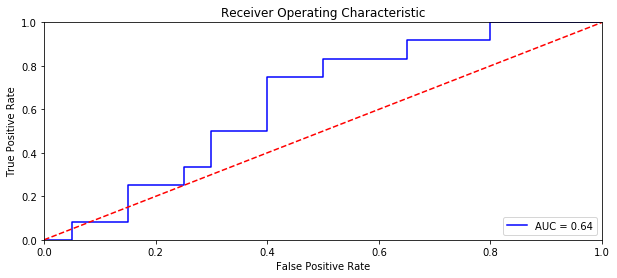

In [29]:
print('Area under ROC curve: %s'%(metrics.roc_auc_score(y_test,y_hat_new)))
plt.figure(figsize=(10,4))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [35]:
kek = pd.DataFrame({'GRUBTCPRC' : np.array(y_hat)})
kek.to_csv('data2.csv', index = False)

In [36]:
kek

,GRUBTCPRC
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0
